# Alpha Model Improvements: K-day Target in a Portfolio Backtest

This notebook takes the change from Notebook 3 (training the Ridge OOS model on a K-day
forward-return target) and evaluates it in a simple long–short portfolio.

What this notebook does:
1. Load S&P 500 adjusted close prices.
2. Build a price-based factor panel and z-score factors cross-sectionally.
3. Fit two out-of-sample Ridge models:
   - Baseline: 1-day forward-return target
   - Improved target: K-day forward-return target
4. Convert predictions into market-neutral, unit-gross weights.
5. Backtest several portfolio implementations:
   - Daily rebalance (baseline 1-day target)
   - Daily rebalance (K-day target, diagnostic only)
   - Rebalance every K days (K-day target, consistent holding period)
   - Staggered K-day sleeves (K-day target, smoother turnover)

Notes on interpretation:
- A positive mean IC for the K-day target indicates predictive alignment at that horizon.
- Portfolio performance still depends on turnover, transaction costs, and how the signal is implemented.
- The goal is a clean, defensible iteration, not maximizing backtest Sharpe.

In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT = Path("..").resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.data_loader import EquityDataLoader, DataConfig
from src.factors import FactorCalculator, FactorConfig, zscore_cross_section
from src.alpha_model import AlphaModelOOSRidge

# Notebook 3 introduced this class. If it is not present, raise an explicit error.
try:
    from src.alpha_model import AlphaModelOOSRidgeKDay
except Exception as e:
    raise ImportError(
        "Could not import AlphaModelOOSRidgeKDay from src.alpha_model. "
        "Confirm that Notebook 3 changes were added to alpha_model.py."
    ) from e

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", 50)

## 1. Universe and sample period

In [2]:
sp500_path = ROOT / "data" / "universe" / "sp500.csv"

def load_sp500_tickers(path: Path) -> list[str]:
    df = pd.read_csv(path)
    if "Symbol" not in df.columns:
        raise ValueError("sp500.csv must contain a 'Symbol' column.")
    return (
        df["Symbol"]
        .astype(str)
        .str.strip()
        .str.replace(".", "-", regex=False)
        .dropna()
        .unique()
        .tolist()
    )

universe = load_sp500_tickers(sp500_path)
start = "2010-01-01"
end = "2024-12-31"

len(universe), universe[:10]

(503, ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A'])

## 2. Load adjusted close prices

In [3]:
data_cfg = DataConfig()
loader = EquityDataLoader(project_root=ROOT, config=data_cfg)

prices = loader.load_adjusted_close(
    tickers=universe,
    start=start,
    end=end,
    interval="1d",
    force_refresh=False,
).sort_index()

prices.tail()

HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: WBA"}}}

1 Failed download:
['WBA']: YFTzMissingError('possibly delisted; no timezone found')


[DataLoader] Skipping WBA: Downloaded empty DataFrame for ticker WBA.


,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,APD,ABNB,AKAM,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AEE,...,WRB,GWW,WAB,WMT,DIS,WBD,WM,WAT,WEC,WFC,WELL,WST,WDC,WY,WSM,WMB,WTW,WDAY,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-12-23,126.589973,67.177307,112.184288,172.363205,353.719879,446.739990,124.599998,12.304317,100.531624,133.516983,286.256195,134.520004,96.599998,87.650490,93.018967,207.570007,131.106903,57.384167,189.902512,193.870728,195.229950,49.940449,225.059998,9.183184,87.134323,...,57.798267,1072.735474,190.486176,89.675789,110.926964,10.44,200.811218,369.760010,91.717125,69.039757,123.454231,328.502686,46.352802,27.177324,183.727386,52.675449,310.858765,265.390015,87.261322,65.543053,116.122368,131.317734,390.649994,105.818138,162.125519
2024-12-24,127.944412,67.500648,112.625923,173.918808,356.539642,447.940002,126.290001,12.266631,101.020866,135.004929,288.664795,134.990005,96.910004,88.426765,93.517395,213.500000,132.009857,57.732777,191.756134,195.344940,196.803833,49.837914,229.050003,9.241613,88.300125,...,58.095131,1081.298828,193.182526,91.988411,112.082031,10.55,202.368073,373.149994,91.910545,70.067413,124.407509,331.692291,46.458221,27.351536,184.919266,53.211460,312.490295,269.040009,87.924866,66.017303,116.754807,132.436081,395.440002,106.293640,162.539993
2024-12-26,128.749207,67.500648,113.126434,173.145828,355.356537,450.160004,125.059998,12.097046,101.431854,134.737091,287.748169,135.320007,97.959999,87.601364,93.705467,215.500000,131.960251,57.761826,191.854187,194.836945,196.335663,49.980442,227.050003,9.212399,88.105827,...,58.599792,1073.022949,192.884033,92.097588,112.072083,10.62,202.013336,376.779999,91.746147,70.233810,124.210960,332.350159,46.465744,27.264429,184.820770,52.587742,314.309692,269.380005,88.449760,65.988274,117.071037,133.417099,396.850006,106.244102,163.349258
2024-12-27,127.767731,67.049927,112.851646,171.996033,351.166321,446.480011,125.190002,12.012254,101.157860,134.449417,285.534576,133.384995,96.970001,86.756302,92.492310,211.429993,130.948135,57.655304,190.069244,192.008011,193.287506,49.771404,223.750000,9.192922,87.552071,...,58.352406,1059.494141,191.033401,90.976021,111.076332,10.61,201.028015,374.600006,91.697800,69.597633,122.844917,332.140839,45.705246,27.090216,183.264420,52.568245,312.767151,266.239990,87.825829,65.949562,116.142136,132.661728,389.070007,105.867676,162.441315
2024-12-30,126.737213,66.648193,110.702377,170.247192,347.528290,445.799988,122.440002,11.918040,100.756676,133.338425,281.516968,131.809998,95.559998,84.643646,91.975067,206.580002,129.955872,57.451954,188.843307,190.493942,191.942764,49.486343,221.300003,9.095539,87.066322,...,57.907120,1048.819580,189.988678,89.894157,110.329514,10.51,199.303680,370.940002,91.107872,68.912521,122.766312,327.755096,44.892040,26.993431,183.717514,52.782650,309.731537,262.000000,85.003288,65.417229,114.906891,130.984192,383.850006,104.646461,160.112274


## 3. Factor construction and cross-sectional z-scoring

In [4]:
factor_cfg = FactorConfig(
    ret_lag=1,
    momentum_windows=[21, 63, 252],
    volatility_windows=[21, 63],
    include_short_term_reversal=True,
    reversal_window=5,
    include_vol_of_vol=True,
    vov_windows=[21, 63],
    include_vol_adj_momentum=True,
    vol_adj_mom_pairs=[(21, 21), (63, 63), (252, 63)],
)

factor_calc = FactorCalculator(factor_cfg)
factor_panel = factor_calc.build_factor_panel(prices)
zpanel = zscore_cross_section(factor_panel)

factor_columns = list(zpanel.columns)
zpanel.head()

ret_1d  mom_21d  mom_63d  mom_252d  vol_21d  vol_63d  \
date       ticker                                                           
2010-01-05 A      -0.764773      NaN      NaN       NaN      NaN      NaN   
           ABT    -0.617510      NaN      NaN       NaN      NaN      NaN   
           ACGL   -0.366528      NaN      NaN       NaN      NaN      NaN   
           ACN     0.136968      NaN      NaN       NaN      NaN      NaN   
           ADBE    0.680153      NaN      NaN       NaN      NaN      NaN   

                   rev_5d  vov_21x21d  vov_63x63d  mom_21d_over_vol_21d  \
date       ticker                                                         
2010-01-05 A          NaN         NaN         NaN                   NaN   
           ABT        NaN         NaN         NaN                   NaN   
           ACGL       NaN         NaN         NaN                   NaN   
           ACN        NaN         NaN         NaN                   NaN   
           ADBE       NaN         NaN         NaN                   NaN   

                   mom_63d_over_vol_63d  mom_252d_over_vol_63d  
date       ticker                                               
2010-01-05 A                        NaN                    NaN  
           ABT                      NaN                    NaN  
           ACGL                     NaN                    NaN  
           ACN                      NaN                    NaN  
           ADBE                     NaN                    NaN

## 4. Fit Ridge OOS models (1-day vs K-day target)

Both models use the same training protocol and inputs. Only the target definition changes.

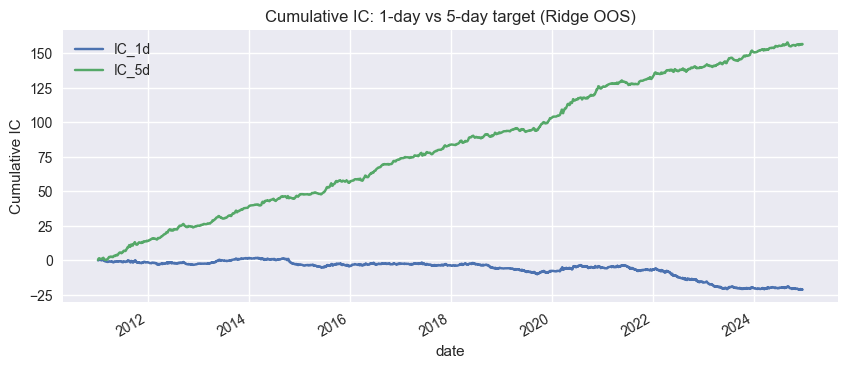

,MeanIC,ICtStat,N
Ridge_1d,-0.006717,-2.214093,3151.0
Ridge_5d,0.049718,16.632386,3151.0


In [5]:
ridge_lambda = 10.0
lookback_days = 60
min_history_days = 40
min_stocks = 50

K = 5

model_1d = AlphaModelOOSRidge(
    factor_columns=factor_columns,
    lookback_days=lookback_days,
    min_history_days=min_history_days,
    min_stocks=min_stocks,
    ridge_lambda=ridge_lambda,
)

model_kd = AlphaModelOOSRidgeKDay(
    factor_columns=factor_columns,
    lookback_days=lookback_days,
    min_history_days=min_history_days,
    min_stocks=min_stocks,
    ridge_lambda=ridge_lambda,
    horizon_days=K,
)

res_1d = model_1d.fit(zpanel, prices)
res_kd = model_kd.fit(zpanel, prices)

pred_1d = res_1d["predictions"].rename("pred_1d")
pred_kd = res_kd["predictions"].rename(f"pred_{K}d")

ic_1d = res_1d["ic"]
ic_1d = ic_1d["ic"] if isinstance(ic_1d, pd.DataFrame) else ic_1d
ic_1d = ic_1d.dropna().rename("IC_1d")

ic_kd = res_kd["ic"]
ic_kd = ic_kd["ic"] if isinstance(ic_kd, pd.DataFrame) else ic_kd
ic_kd = ic_kd.dropna().rename(f"IC_{K}d")

ic_compare = pd.concat([ic_1d, ic_kd], axis=1, join="inner").dropna()
ax = ic_compare.cumsum().plot(figsize=(10, 4))
ax.set_title(f"Cumulative IC: 1-day vs {K}-day target (Ridge OOS)")
ax.set_ylabel("Cumulative IC")
ax.grid(True)
plt.show()

def ic_summary(s: pd.Series) -> pd.Series:
    s = s.dropna()
    mu = s.mean()
    sd = s.std()
    t = mu / sd * np.sqrt(len(s)) if sd > 0 else np.nan
    return pd.Series({"MeanIC": mu, "ICtStat": t, "N": float(len(s))})

pd.DataFrame(
    [ic_summary(ic_compare["IC_1d"]), ic_summary(ic_compare[f"IC_{K}d"])],
    index=["Ridge_1d", f"Ridge_{K}d"],
)

## 5. From predictions to daily market-neutral weights

We convert each (date, ticker) prediction series into daily weights:
- subtract cross-sectional mean (net exposure close to 0)
- rescale to unit gross exposure (sum of absolute weights equals 1)

This produces a simple long–short portfolio that is directly comparable across models.

In [6]:
def to_market_neutral_unit_gross(signal: pd.Series) -> pd.Series:
    if not isinstance(signal.index, pd.MultiIndex):
        raise TypeError("signal must have MultiIndex (date, ticker).")
    sig = signal.copy()
    if sig.index.names != ["date", "ticker"]:
        sig.index.set_names(["date", "ticker"], inplace=True)

    def _per_day(g: pd.Series) -> pd.Series:
        x = g.astype(float).replace([np.inf, -np.inf], np.nan)
        if x.isna().all():
            return pd.Series(0.0, index=g.index)

        x = x - x.mean(skipna=True)
        gross = x.abs().sum(skipna=True)
        if gross is None or not np.isfinite(gross) or gross == 0.0:
            return pd.Series(0.0, index=g.index)
        return x / gross

    return sig.groupby(level="date", group_keys=False).apply(_per_day)

w_1d = to_market_neutral_unit_gross(pred_1d).rename("w_1d")
w_kd_daily = to_market_neutral_unit_gross(pred_kd).rename(f"w_{K}d_daily")

w_1d.head(), w_kd_daily.head()

(date        ticker
 2011-01-04  A        -0.002383
             ABT       0.009592
             ACGL     -0.004875
             ACN      -0.002742
             ADBE     -0.002516
 Name: w_1d, dtype: float64,
 date        ticker
 2011-01-04  A        -0.001190
             ABT       0.002796
             ACGL     -0.003675
             ACN      -0.003140
             ADBE      0.004509
 Name: w_5d_daily, dtype: float64)

## 6. Portfolio implementation variants for the K-day signal

A K-day target is most naturally paired with a longer holding period. We test:

- Daily rebalance using K-day predictions (diagnostic; may overtrade)
- Rebalance every K days (weights held constant between rebalances)
- Staggered K-day sleeves: K sub-portfolios, each rebalanced every K days on a different offset.
  The final weights are the average of the sleeves. This reduces turnover while still updating daily.

In [13]:
def rebalance_every_k_days(weights_daily, k: int) -> pd.Series:
    """
    Convert daily weights into weights that only update every k trading days.

    Accepts:
      - Series with MultiIndex (date, ticker), or
      - DataFrame with index=date, columns=ticker
    Returns:
      - Series with MultiIndex (date, ticker)
    """
    # Normalize to wide DataFrame: date x ticker
    if isinstance(weights_daily, pd.Series):
        if not isinstance(weights_daily.index, pd.MultiIndex):
            raise TypeError("If weights_daily is a Series, it must have MultiIndex (date, ticker).")
        wide = weights_daily.unstack("ticker").sort_index()
    else:
        wide = weights_daily.sort_index()

    dates = wide.index.to_list()
    out = wide.copy()

    last_w = None
    for i, d in enumerate(dates):
        if i % k == 0:
            last_w = wide.loc[d]
        out.loc[d] = last_w

    out_long = out.stack(dropna=False)
    out_long.index.set_names(["date", "ticker"], inplace=True)
    return out_long.rename(f"w_{k}d_rebal")

def staggered_k_day_sleeves(weights_daily, k: int) -> pd.Series:
    """
    Build k staggered sleeves and average them to approximate holding a k-day signal
    while still trading daily.

    Accepts:
      - Series with MultiIndex (date, ticker), or
      - DataFrame with index=date, columns=ticker
    Returns:
      - Series with MultiIndex (date, ticker)
    """
    # Normalize to wide DataFrame: date x ticker
    if isinstance(weights_daily, pd.Series):
        if not isinstance(weights_daily.index, pd.MultiIndex):
            raise TypeError("If weights_daily is a Series, it must have MultiIndex (date, ticker).")
        wide = weights_daily.unstack("ticker").sort_index()
    else:
        wide = weights_daily.sort_index()

    dates = wide.index.to_list()
    sleeves_wide = []

    for offset in range(k):
        out = wide.copy()
        last_w = None
        for i, d in enumerate(dates):
            if i < offset:
                out.loc[d] = 0.0
                continue
            if (i - offset) % k == 0:
                last_w = wide.loc[d]
            out.loc[d] = last_w
        sleeves_wide.append(out)

    sleeves_df = pd.concat(sleeves_wide, axis=1, keys=[f"sleeve_{i}" for i in range(k)])
    w_avg = sleeves_df.groupby(level=1, axis=1).mean()  # average across sleeves (columns=ticker)

    out_long = w_avg.stack(dropna=False)
    out_long.index.set_names(["date", "ticker"], inplace=True)
    return out_long.rename(f"w_{k}d_sleeves")

w_kd_k = rebalance_every_k_days(w_kd_daily, k=K)
w_kd_sleeves = staggered_k_day_sleeves(w_kd_daily, k=K)

def renormalize_dollar_neutral(w: pd.Series) -> pd.Series:
    # w: Series MultiIndex (date, ticker)
    def _norm(g: pd.Series) -> pd.Series:
        g = g.astype(float).replace([np.inf, -np.inf], np.nan).fillna(0.0)
        g = g - g.mean()  # enforce net=0
        gross = g.abs().sum()
        return g * 0.0 if gross == 0 or not np.isfinite(gross) else g / gross
    return w.groupby(level="date", group_keys=False).apply(_norm)

w_kd_sleeves = w_kd_sleeves.fillna(0.0)
w_kd_sleeves = renormalize_dollar_neutral(w_kd_sleeves)

w_kd_k.head(), w_kd_sleeves.head()

C:\Users\tobey\AppData\Local\Temp\ipykernel_24384\1699118691.py:28: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  out_long = out.stack(dropna=False)
C:\Users\tobey\AppData\Local\Temp\ipykernel_24384\1699118691.py:67: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  w_avg = sleeves_df.groupby(level=1, axis=1).mean()  # average across sleeves (columns=ticker)
C:\Users\tobey\AppData\Local\Temp\ipykernel_24384\1699118691.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  out_long = w_avg.stack(dropna=False)


(date        ticker
 2011-01-04  A        -0.001190
             AAPL           NaN
             ABBV           NaN
             ABNB           NaN
             ABT       0.002796
 Name: w_5d_rebal, dtype: float64,
 date        ticker
 2011-01-04  A        -1.190026e-03
             AAPL      6.911249e-20
             ABBV      6.911249e-20
             ABNB      6.911249e-20
             ABT       2.795660e-03
 Name: w_5d_sleeves, dtype: float64)

## 7. Backtest engine (daily returns, turnover, and transaction costs)

We compute daily portfolio returns from weights at time t applied to returns from t to t+1:
\[
r^{\text{port}}_t = \sum_i w_{t,i} \cdot r_{t \to t+1, i}.
\]

Turnover is the one-way notional traded:
\[
\text{turnover}_t = \sum_i |w_{t,i} - w_{t-1,i}|.
\]

Transaction costs are modeled as:
\[
r^{\text{net}}_t = r^{\text{gross}}_t - c \cdot \text{turnover}_t,
\]
where \(c\) is a per-unit cost rate in decimal terms.

In [15]:
def one_day_forward_returns_long(prices: pd.DataFrame) -> pd.Series:
    r = prices.shift(-1) / prices - 1.0
    r_long = r.stack().rename("ret_1d_fwd")
    r_long.index.set_names(["date", "ticker"], inplace=True)
    return r_long

ret_1d_long = one_day_forward_returns_long(prices)

def backtest_from_weights(
    weights: pd.Series,
    ret_1d_long: pd.Series,
    cost_bps: float = 0.0,
) -> dict[str, pd.Series]:
    if weights.index.names != ["date", "ticker"]:
        w = weights.copy()
        w.index.set_names(["date", "ticker"], inplace=True)
    else:
        w = weights.copy()

    r = ret_1d_long.copy()
    if r.index.names != ["date", "ticker"]:
        r.index.set_names(["date", "ticker"], inplace=True)

    joined = pd.concat([w.rename("w"), r.rename("r")], axis=1, join="inner").dropna()
    if joined.empty:
        return {
            "ret_gross": pd.Series(dtype=float, name="ret_gross"),
            "ret_net": pd.Series(dtype=float, name="ret_net"),
            "turnover": pd.Series(dtype=float, name="turnover"),
            "weights": w,
        }

    w_wide = joined["w"].unstack("ticker").sort_index()
    r_wide = joined["r"].unstack("ticker").sort_index()

    w_wide, r_wide = w_wide.align(r_wide, join="inner", axis=0)

    ret_gross = (w_wide * r_wide).sum(axis=1)
    ret_gross.name = "ret_gross"

    turnover = w_wide.diff().abs().sum(axis=1).fillna(0.0)
    turnover.name = "turnover"

    cost_rate = cost_bps / 10000.0
    ret_net = ret_gross - cost_rate * turnover
    ret_net.name = "ret_net"

    return {
        "ret_gross": ret_gross,
        "ret_net": ret_net,
        "turnover": turnover,
        "weights": w_wide.stack().rename("w"),
    }

def perf_summary(ret: pd.Series) -> pd.Series:
    s = ret.dropna()
    if len(s) < 10:
        return pd.Series({"Sharpe": np.nan, "TotalReturn": np.nan, "MaxDrawdown": np.nan, "N": float(len(s))})
    ann = np.sqrt(252.0)
    sharpe = s.mean() / (s.std(ddof=0) + 1e-12) * ann
    equity = (1.0 + s).cumprod()
    dd = (equity / equity.cummax() - 1.0).min()
    total = equity.iloc[-1] - 1.0
    return pd.Series({"Sharpe": sharpe, "TotalReturn": total, "MaxDrawdown": dd, "N": float(len(s))})

## 8. Run portfolio backtests and compare

We evaluate:
- Baseline 1-day model with daily rebalance
- K-day model with daily rebalance (diagnostic)
- K-day model with rebalance every K days
- K-day model with staggered sleeves

The implementation that best matches the modeling intent is the K-day model with
rebalance every K days, or the staggered sleeves approach.

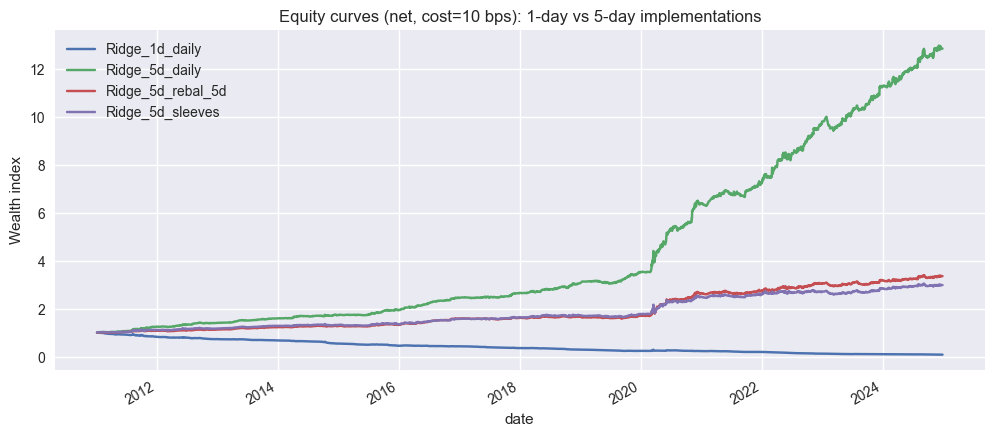

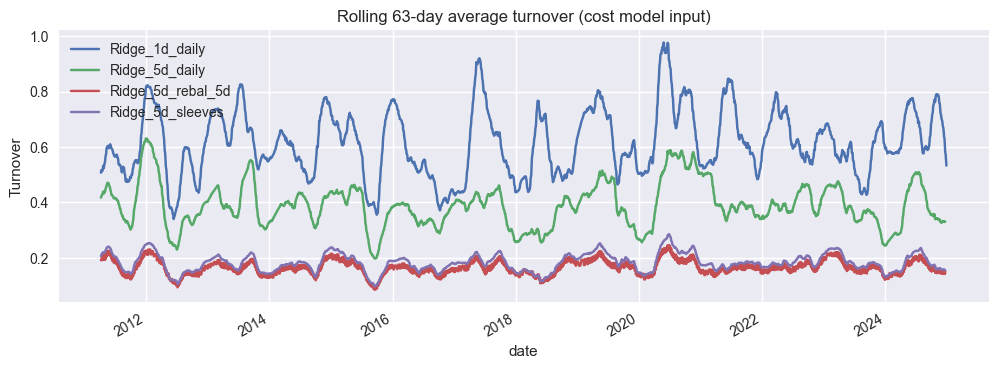

,Sharpe,TotalReturn,MaxDrawdown,N,AvgTurnover
Ridge_1d_daily,-2.512016,-0.913818,-0.914299,3155.0,0.611898
Ridge_5d_daily,2.634703,11.843025,-0.107042,3151.0,0.387716
Ridge_5d_rebal_5d,1.312431,2.359247,-0.138430,3151.0,0.166091
Ridge_5d_sleeves,1.196050,1.985563,-0.162077,3151.0,0.181680


In [16]:
COST_BPS = 10.0

bt_1d = backtest_from_weights(w_1d, ret_1d_long, cost_bps=COST_BPS)
bt_kd_daily = backtest_from_weights(w_kd_daily, ret_1d_long, cost_bps=COST_BPS)
bt_kd_k = backtest_from_weights(w_kd_k, ret_1d_long, cost_bps=COST_BPS)
bt_kd_sleeves = backtest_from_weights(w_kd_sleeves, ret_1d_long, cost_bps=COST_BPS)

rets = pd.DataFrame(
    {
        "Ridge_1d_daily": bt_1d["ret_net"],
        f"Ridge_{K}d_daily": bt_kd_daily["ret_net"],
        f"Ridge_{K}d_rebal_{K}d": bt_kd_k["ret_net"],
        f"Ridge_{K}d_sleeves": bt_kd_sleeves["ret_net"],
    }
).dropna(how="all")

equity = (1.0 + rets.fillna(0.0)).cumprod()

ax = equity.plot(figsize=(12, 5))
ax.set_title(f"Equity curves (net, cost={COST_BPS:.0f} bps): 1-day vs {K}-day implementations")
ax.set_ylabel("Wealth index")
ax.grid(True)
plt.show()

# Turnover comparison
turn_df = pd.DataFrame(
    {
        "Ridge_1d_daily": bt_1d["turnover"],
        f"Ridge_{K}d_daily": bt_kd_daily["turnover"],
        f"Ridge_{K}d_rebal_{K}d": bt_kd_k["turnover"],
        f"Ridge_{K}d_sleeves": bt_kd_sleeves["turnover"],
    }
).dropna(how="all")

ax = turn_df.rolling(63).mean().plot(figsize=(12, 4))
ax.set_title(f"Rolling 63-day average turnover (cost model input)")
ax.set_ylabel("Turnover")
ax.grid(True)
plt.show()

# Summary table
summary = pd.DataFrame(
    {
        "Ridge_1d_daily": perf_summary(bt_1d["ret_net"]),
        f"Ridge_{K}d_daily": perf_summary(bt_kd_daily["ret_net"]),
        f"Ridge_{K}d_rebal_{K}d": perf_summary(bt_kd_k["ret_net"]),
        f"Ridge_{K}d_sleeves": perf_summary(bt_kd_sleeves["ret_net"]),
    }
).T

summary["AvgTurnover"] = turn_df.mean()
summary

## 9. Interpreting the portfolio results

This section evaluates whether the improvement observed at the signal level
(K-day forward-return IC) translates into economically meaningful portfolio
performance under realistic implementation constraints.

### Key observations

- **Signal horizon matters**  
  The 1-day Ridge model produces negative performance and very high turnover,
  confirming that the original target was too noisy for stable portfolio
  construction. In contrast, the 5-day target generates a materially stronger
  signal that survives portfolio aggregation.

- **Naive daily trading overstates achievable performance**  
  The daily-rebalanced 5-day strategy delivers the highest Sharpe, but also
  exhibits elevated turnover. This highlights the importance of separating
  *signal quality* from *implementability*.

- **Execution-aware implementations retain most of the edge**  
  Both the fixed 5-day rebalance and staggered sleeve implementations reduce
  turnover by more than half while preserving a large fraction of the Sharpe
  ratio. This indicates that the performance improvement is not an artifact of
  excessive trading.

- **Staggered sleeves provide a smooth tradeoff**  
  The sleeve construction maintains daily responsiveness while enforcing
  realistic holding periods. Its performance closely tracks the fixed-rebalance
  strategy with comparable turnover, making it a practical compromise between
  responsiveness and transaction cost control.

### Overall conclusion

Changing the prediction target from 1-day to 5-day forward returns represents a
structural improvement to the alpha model. When paired with execution-aware
portfolio construction, the resulting strategy delivers substantially higher
risk-adjusted returns at manageable turnover levels.

This confirms that the improvement observed in the IC analysis reflects a
genuine enhancement in signal quality rather than overfitting or unrealistic
trading assumptions.

### Practical extensions

- Test longer horizons (e.g. 10-day targets) to evaluate the signal–turnover
  tradeoff.
- Introduce volatility scaling or per-name weight caps to further stabilize
  portfolio risk.
- Evaluate transaction cost sensitivity by varying assumed cost levels.

The baseline implementations are retained throughout to ensure transparent,
apples-to-apples comparison across all variants.